# Visualización para exploración

El objetivo es utilizar distintos tipos de gráficos para acercarnos a los datos.

Voy a utilizar la base de Covid19 que disponibiliza el Ministerio de Salud:
http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina

Primero descargamos las principales librerías para gráficos (Matplotlib y Seaborn) y hacemos algo de limpieza en la base. Me voy a concentrar solo en confirmados para hacer la base más chica y manejable.

In [1]:
import pandas as pd
pd.set_option('display.max_columns',30)
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
datacovid=pd.read_csv('Covid19Casos.csv')

In [3]:
datacovid=datacovid[datacovid['clasificacion_resumen']=='Confirmado']

In [4]:
datacovid['clasificacion_resumen'].value_counts()

Confirmado    3539484
Name: clasificacion_resumen, dtype: int64

Está bueno analizar los NAs para ver qué información es representativa, si bien fecha de diagnostico no tiene tantos NAs no la voy a utilizar para los gràficos así que a los fines prácticos la elimino

In [5]:
datacovid.isnull().sum()

id_evento_caso                            0
sexo                                      0
edad                                    949
edad_años_meses                           0
residencia_pais_nombre                    0
residencia_provincia_nombre               0
residencia_departamento_nombre            0
carga_provincia_nombre                    0
fecha_inicio_sintomas               1481236
fecha_apertura                            0
sepi_apertura                             0
fecha_internacion                   3391645
cuidado_intensivo                         0
fecha_cui_intensivo                 3512108
fallecido                                 0
fecha_fallecimiento                 3465421
asistencia_respiratoria_mecanica          0
carga_provincia_id                        0
origen_financiamiento                     0
clasificacion                             0
clasificacion_resumen                     0
residencia_provincia_id                   0
fecha_diagnostico               

In [6]:
datacovid.shape

(3539484, 25)

In [142]:
cols_a_eliminar=['fecha_inicio_sintomas','fecha_internacion','fecha_cui_intensivo','fecha_fallecimiento','fecha_diagnostico']
datacovidnew=datacovid.drop(cols_a_eliminar,axis=1)
datacovidnew=datacovidnew.dropna(subset=['fecha_apertura','edad'],axis=0)
datacovidnew['fecha_apertura']=pd.to_datetime(datacovidnew['fecha_apertura'])

In [143]:
datacovidnew.isnull().sum()

id_evento_caso                      0
sexo                                0
edad                                0
edad_años_meses                     0
residencia_pais_nombre              0
residencia_provincia_nombre         0
residencia_departamento_nombre      0
carga_provincia_nombre              0
fecha_apertura                      0
sepi_apertura                       0
cuidado_intensivo                   0
fallecido                           0
asistencia_respiratoria_mecanica    0
carga_provincia_id                  0
origen_financiamiento               0
clasificacion                       0
clasificacion_resumen               0
residencia_provincia_id             0
residencia_departamento_id          0
ultima_actualizacion                0
dtype: int64

# Lineplot

Vamos a arrancar con un gráfico bien simple, de linea, que se utiliza para series de tiempo. 
Para este ejercicio graficamos confirmados y fallecidos por mes. Antes de graficar, agregamos una columna para mensualizar la fecha y convertimos fallecidos en una variable binaria para poder sumarla.

In [6]:
datacovidnew['mes_año'] = datacovidnew['fecha_apertura'].dt.strftime('%Y-%m')
datacovidnew['fallecido']=datacovidnew['fallecido'].apply(lambda x: 1 if x=='SI' else 0)
datos_pormes=datacovidnew.groupby("mes_año", as_index=True).agg({"id_evento_caso":"count", "fallecido":"sum"})
datos_pormes.rename(columns={'id_evento_caso':'confirmados','fallecido':'fallecidos'},inplace=True)

In [31]:
datos_pormes

,confirmados,fallecidos
mes_año,,
2020-03,1504,91
2020-04,4673,394
2020-05,15849,809
2020-06,56534,2440
2020-07,141857,5791
2020-08,239757,8187
2020-09,337269,10169
2020-10,406827,10115
2020-11,254171,5361


Ahora sí, yendo al gráfico usé Seaborn pero podría haber usado plt.plot. Al solaparse las etiquetas tuve que especificar la leyenda 'agregando' las mismas. 

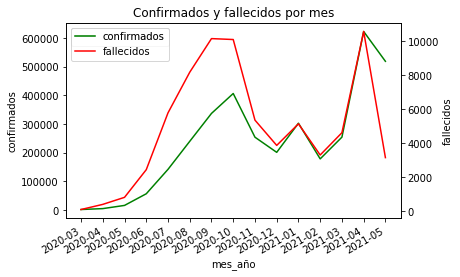

In [7]:
ax=sns.lineplot(x=datos_pormes.index,y=datos_pormes['confirmados'],color='g',label='confirmados')
ax2 = plt.twinx()
sns.lineplot(data=datos_pormes.fallecidos, color="r", ax=ax2,label='fallecidos')
ax2.set_ylabel(r"fallecidos")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Confirmados y fallecidos por mes')
plt.gcf().autofmt_xdate()

# Countplot / Barplot

Los gráficos de barras se utilizan para realizar comparaciones con variables categóricas. Vamos a rankear los departamentos de Buenos Aires con más casos confirmados.

In [8]:
dataBA=datacovidnew[datacovidnew['carga_provincia_nombre']=='Buenos Aires']

In [9]:
dataBAtop10=dataBA.residencia_departamento_nombre.value_counts().head(10)

In [10]:
dataBAselec=dataBA[dataBA['residencia_departamento_nombre'].isin(dataBAtop10.index)]

Arrancamos con Countplot que es básicamente un contador de observaciones. Como quería barras horizontales tuve que poner la variable de interés en el eje y

Text(0.5, 1.0, 'Partidos de Buenos Aires con más confirmados')

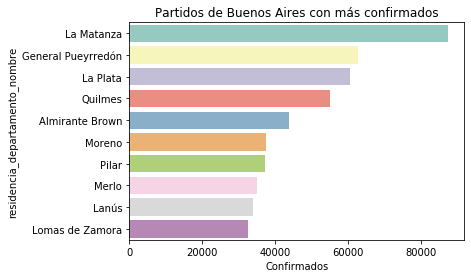

In [17]:
sns.countplot(y="residencia_departamento_nombre", data=dataBAselec,palette='Set3',order = dataBAselec['residencia_departamento_nombre'].value_counts().index)
plt.xlabel('Confirmados')
plt.title('Partidos de Buenos Aires con más confirmados')

Versión más simple con plot

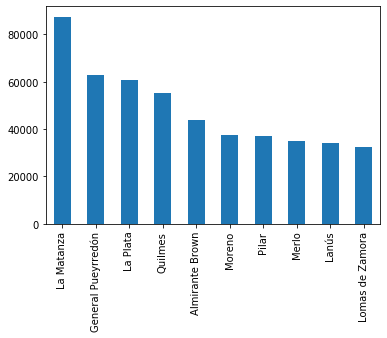

In [15]:
dataBAselec['residencia_departamento_nombre'].value_counts().plot(kind="bar")

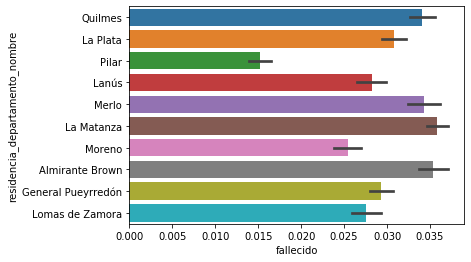

In [19]:
sns.barplot(y='residencia_departamento_nombre',x='fallecido',data=dataBAselec,orient='h')

El barplot muestra por default la media de la variable. En este caso estamos viendo el promedio de fallecidos (uno si es fallecido) del total de confirmados. Es decir en Almirante Brown o La Matanza la mortalidad de los confirmados es de 3.5% mientras que en Pilar por ejemplo cae a menos del 1.5%. A veces puede ser difícil de interpretar por eso si estuviéramos interesados en las cantidades por ahí un histograma es más adecuado.
Para clarificar qué hizo el barplot saco el ejemplo de Almirant Brown:

In [21]:
Atebrown=dataBAselec[dataBAselec['residencia_departamento_nombre']=='Almirante Brown']

In [35]:
print(round(Atebrown.fallecido.sum()/len(Atebrown)*100,2))

3.54


# Histogramas

Los histogramas nos permiten conocer la distribución de las variables. Para probar los histogramas vamos a centrarnos en la edad de los casos confirmados. No sin antes hacer algunos arreglitos en los datos

In [43]:
datacovidnew['edad_años_meses'].value_counts()

Años     3534179
Meses       4356
Name: edad_años_meses, dtype: int64

Vamos a dejar de lado a los lactantes por el momento...

In [44]:
datacovidaños=datacovidnew[datacovidnew['edad_años_meses']=='Años']

In [51]:
datacovidaños=datacovidaños[datacovidaños['edad']>=0] # exluimos confirmados con edad negativa

Dado que también hay valores muy extremos en las edades mayores (dudo que alguien haya llegado a los 150 años de edad) arbitrariamente elimino los casos mayores a 110 años

In [56]:
mayor=datacovidaños[datacovidaños['edad']>110] 

In [57]:
len(mayor)

233

In [60]:
datacovidaños=datacovidaños[datacovidaños['edad']<=110]

Para probar los subplots vamos a hacer dos histogramas, uno para confirmados y otro para fallecidos

In [ ]:
fallec=datacovidaños[datacovidaños['fallecido']==1]

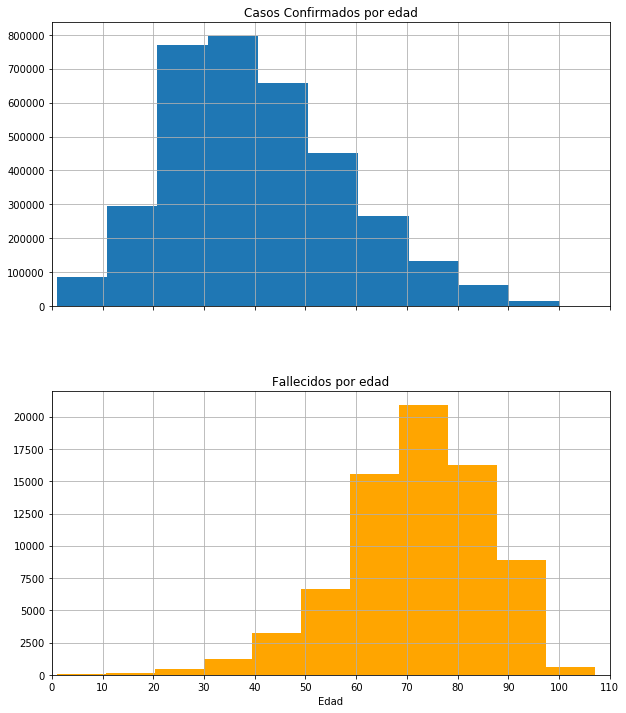

In [99]:
plt.rcParams["figure.figsize"] = (10,12)
fig, axes = plt.subplots(2, 1,sharex=True)

datacovidaños.hist('edad', ax=axes[0],bins=11)
fallec.hist('edad',ax=axes[1],bins=11,color='orange')
axes[0].set_title('Casos Confirmados por edad')
axes[1].set_title('Fallecidos por edad')
plt.setp(axes, xticks=[0,10,20,30,40,50,60,70,80,90,100,110])
plt.xlim(0,110)
axes[1].set_xlabel('Edad')
plt.show()

Si usamos Seaborn tenemos la funcion displot, simple y lindo...

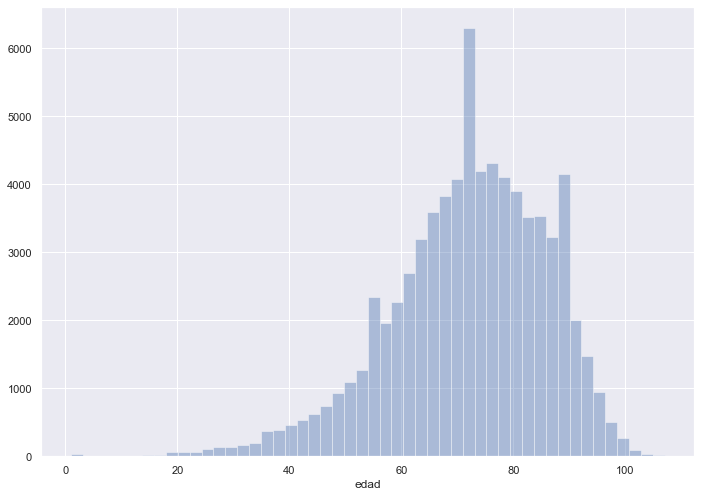

In [106]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(a=fallec['edad'],kde=False)

Los Kernel Density plots nos muestran la distribución de probabilidades de una variable
Para probar los density plots voy a comparar las distribuciones de edad de los confirmados de la ciudad donde crecí (Lanús) y del partido donde vivo ahora (San Isidro)

In [123]:
Lanus=datacovidaños[datacovidaños['residencia_departamento_nombre']=='Lanús']
SI=datacovidaños[datacovidaños['residencia_departamento_nombre']=='San Isidro']
Lanusf=fallec[fallec['residencia_departamento_nombre']=='Lanús']
SIf=fallec[fallec['residencia_departamento_nombre']=='San Isidro']

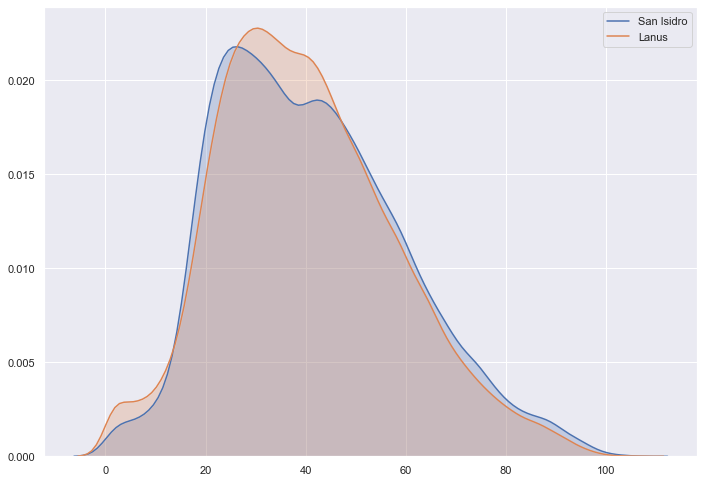

In [122]:
sns.kdeplot(data=SI['edad'], shade=True,label='San Isidro')
sns.kdeplot(data=Lanus['edad'], shade=True,label='Lanus')

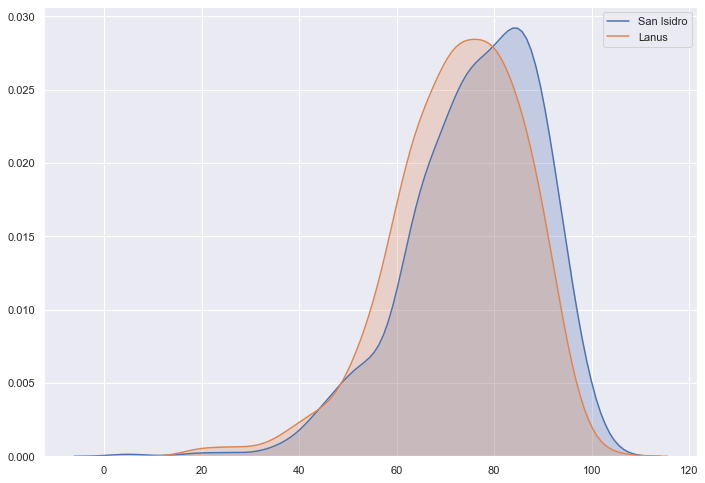

In [124]:
sns.kdeplot(data=SIf['edad'], shade=True,label='San Isidro')
sns.kdeplot(data=Lanusf['edad'], shade=True,label='Lanus')

En San Isidro la expectativa de fallecimiento por covid se da más allá de los 80 años, mientras que en Lanus ese valor se acerca más a 77.

Otro gráfico para analizar distribuciones es el boxplot. La mediana es la raya que separa las "cajas", y estas cajas representan la distancia entre el primer cuartil y el tercer cuartil. Por encima y por debajo de las rayas horizontales a ambos extremos se encuentran ploteados los outliers, representados por pequeños puntitos superpuestos.

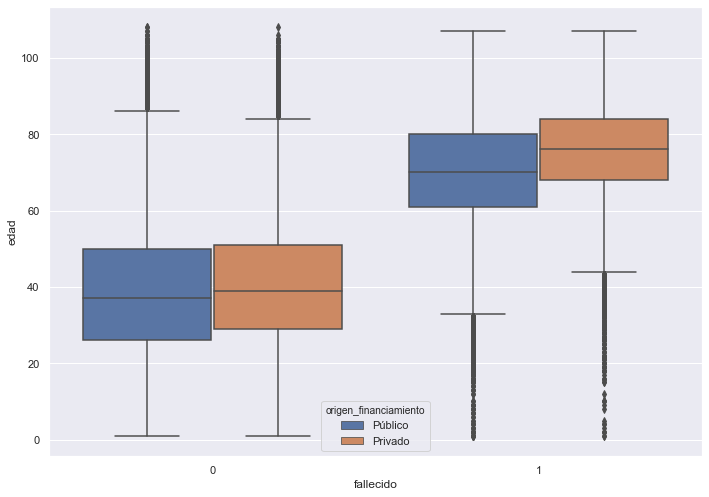

In [138]:
dataFM=datacovidaños[datacovidaños['sexo']!='NR']
sns.boxplot(x="fallecido", y="edad",hue='origen_financiamiento',data=dataFM)

In [140]:
dataFM[dataFM['origen_financiamiento']=='Público'].describe()

,id_evento_caso,edad,sepi_apertura,fallecido,carga_provincia_id,residencia_provincia_id,residencia_departamento_id
count,2.407481e+06,2.407481e+06,2.407481e+06,2.407481e+06,2.407481e+06,2.407481e+06,2.407481e+06
mean,6.959065e+06,3.939888e+01,2.551571e+01,1.744396e-02,3.011056e+01,3.054901e+01,2.011390e+02
std,3.780282e+06,1.726057e+01,1.513922e+01,1.309186e-01,3.165718e+01,3.165486e+01,2.424407e+02
min,7.356990e+05,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00
25%,3.454801e+06,2.700000e+01,1.400000e+01,0.000000e+00,6.000000e+00,6.000000e+00,2.100000e+01
50%,6.541134e+06,3.700000e+01,2.000000e+01,0.000000e+00,1.400000e+01,1.400000e+01,8.400000e+01
75%,1.062892e+07,5.100000e+01,4.000000e+01,0.000000e+00,5.800000e+01,5.800000e+01,3.710000e+02
max,1.308916e+07,1.080000e+02,5.300000e+01,1.000000e+00,9.400000e+01,9.900000e+01,8.820000e+02


Para clarificar mejor lo que indica el boxplot, tomamos de ejemplo el primer boxplot azul de casos confirmados con origen de financiamiento público. Si nos detenemos en 'edad', la mediana es 37 años, el primer cuartil se encuentra en 27 años y el tercer cuartil en 51 años.
La diferencia intercuartil es 51-27=24. El extremo superior que delimita los outliers será 51+1.5*24=87 representado por raya que separa a los outliers

# Gráficos Relacionales: Scatterplots/ Pairplots/ Heatmaps

Para poder encontrar relaciones entre variables voy a juntar esta base con otra que tiene datos sociodemográficos que encontré en Kaggle. Tiene algunos 'flaws', le faltan dos provincias, y probablemente Buenos Aires agrupe la Ciudad de Buenos Aires, pero como el propósito en ensayar tipos de gráfico por practicidad voy a utilizar esta base. 

In [181]:
arg=pd.read_csv('argentina.csv')

In [152]:
arg.head()

,province,gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,movie_theatres_per_cap,doctors_per_cap
0,Buenos Aires,2.926899e+08,1.38324,8.167798,5.511856,0.766168,48.7947,4.4,15625084,0.000006,0.004836
1,Catamarca,6.150949e+06,2.34414,9.234095,10.464484,0.951963,45.0456,1.5,367828,0.000005,0.004502
2,Córdoba,6.936374e+07,2.71414,5.382380,10.436086,1.035056,45.7640,4.8,3308876,0.000011,0.010175
3,Corrientes,7.968013e+06,5.60242,12.747191,17.438858,3.864265,62.1103,5.9,992595,0.000004,0.004495
4,Chaco,9.832643e+06,7.51758,15.862619,31.479527,2.577462,65.5104,7.5,1055259,0.000003,0.003605


In [151]:
datacovidaños['carga_provincia_nombre'].value_counts()

Buenos Aires           1276500
CABA                    646345
Santa Fe                323855
Córdoba                 279471
Tucumán                 121657
Mendoza                 114328
Neuquén                  85379
Entre Ríos               77496
Río Negro                70266
Chubut                   57914
Chaco                    52617
Santa Cruz               49248
San Luis                 48964
Corrientes               48733
Salta                    42038
Santiago del Estero      37953
La Pampa                 37912
San Juan                 33033
Tierra del Fuego         27530
Jujuy                    25965
Formosa                  23377
Catamarca                19930
Misiones                 17582
La Rioja                 15849
Name: carga_provincia_nombre, dtype: int64

In [153]:
arg.province.value_counts()

Formosa                1
Misiones               1
Chaco                  1
Río Negro              1
Jujuy                  1
Entre Ríos             1
Catamarca              1
Corrientes             1
San Juan               1
San Luis               1
La Pampa               1
Mendoza                1
Buenos Aires           1
Neuquén                1
Salta                  1
Chubut                 1
La Rioja               1
Santa Fe               1
Santiago del Estero    1
Santa Cruz             1
Córdoba                1
Tucumán                1
Name: province, dtype: int64

In [154]:
datosprov=datacovidaños.groupby("carga_provincia_nombre", as_index=True).agg({"id_evento_caso":"count", "fallecido":"sum"})

In [182]:
arg=arg.set_index('province')

In [183]:
datosprovnueva=pd.concat([arg,datosprov],axis=1)

In [184]:
datosprovnueva=new.dropna(how='any',axis=0)

In [185]:
datosprovnueva

,gdp,illiteracy,poverty,school_dropout,no_healthcare,birth_mortal,pop,doctors_per_cap,id_evento_caso,fallecido
Buenos Aires,2.926899e+08,1.383240,8.167798,0.766168,48.7947,4.4,15625084.0,0.004836,1276500,36349
Catamarca,6.150949e+06,2.344140,9.234095,0.951963,45.0456,1.5,367828.0,0.004502,19930,145
Córdoba,6.936374e+07,2.714140,5.382380,1.035056,45.7640,4.8,3308876.0,0.010175,279471,3701
Corrientes,7.968013e+06,5.602420,12.747191,3.864265,62.1103,5.9,992595.0,0.004495,48733,572
Chaco,9.832643e+06,7.517580,15.862619,2.577462,65.5104,7.5,1055259.0,0.003605,52617,1153
Chubut,1.774785e+07,1.548060,8.051752,0.586309,39.5473,3.0,509108.0,0.004498,57914,988
Entre Ríos,2.074341e+07,3.185580,7.288751,1.887188,48.6571,3.1,1235994.0,0.004679,77496,1213
Formosa,3.807057e+06,4.610640,17.035583,2.268974,65.8126,16.2,530162.0,0.003440,23377,305
Jujuy,6.484938e+06,2.151390,13.367965,0.721295,54.1615,3.7,673307.0,0.003958,25965,1081
La Pampa,6.990262e+06,1.539300,3.398774,0.204093,45.4764,7.2,318951.0,0.005415,37912,484


In [186]:
cols=['gdp','illiteracy','poverty','school_dropout','birth_mortal','pop','doctors_per_cap','id_evento_caso', 'fallecido']

In [187]:
datosprovnueva=datosprovnueva[cols]

Pairplot nos permite tener un pantallazo rápido de cómo se relacionan las variables, mientras que en la diagonal podemos ver las distribuciones

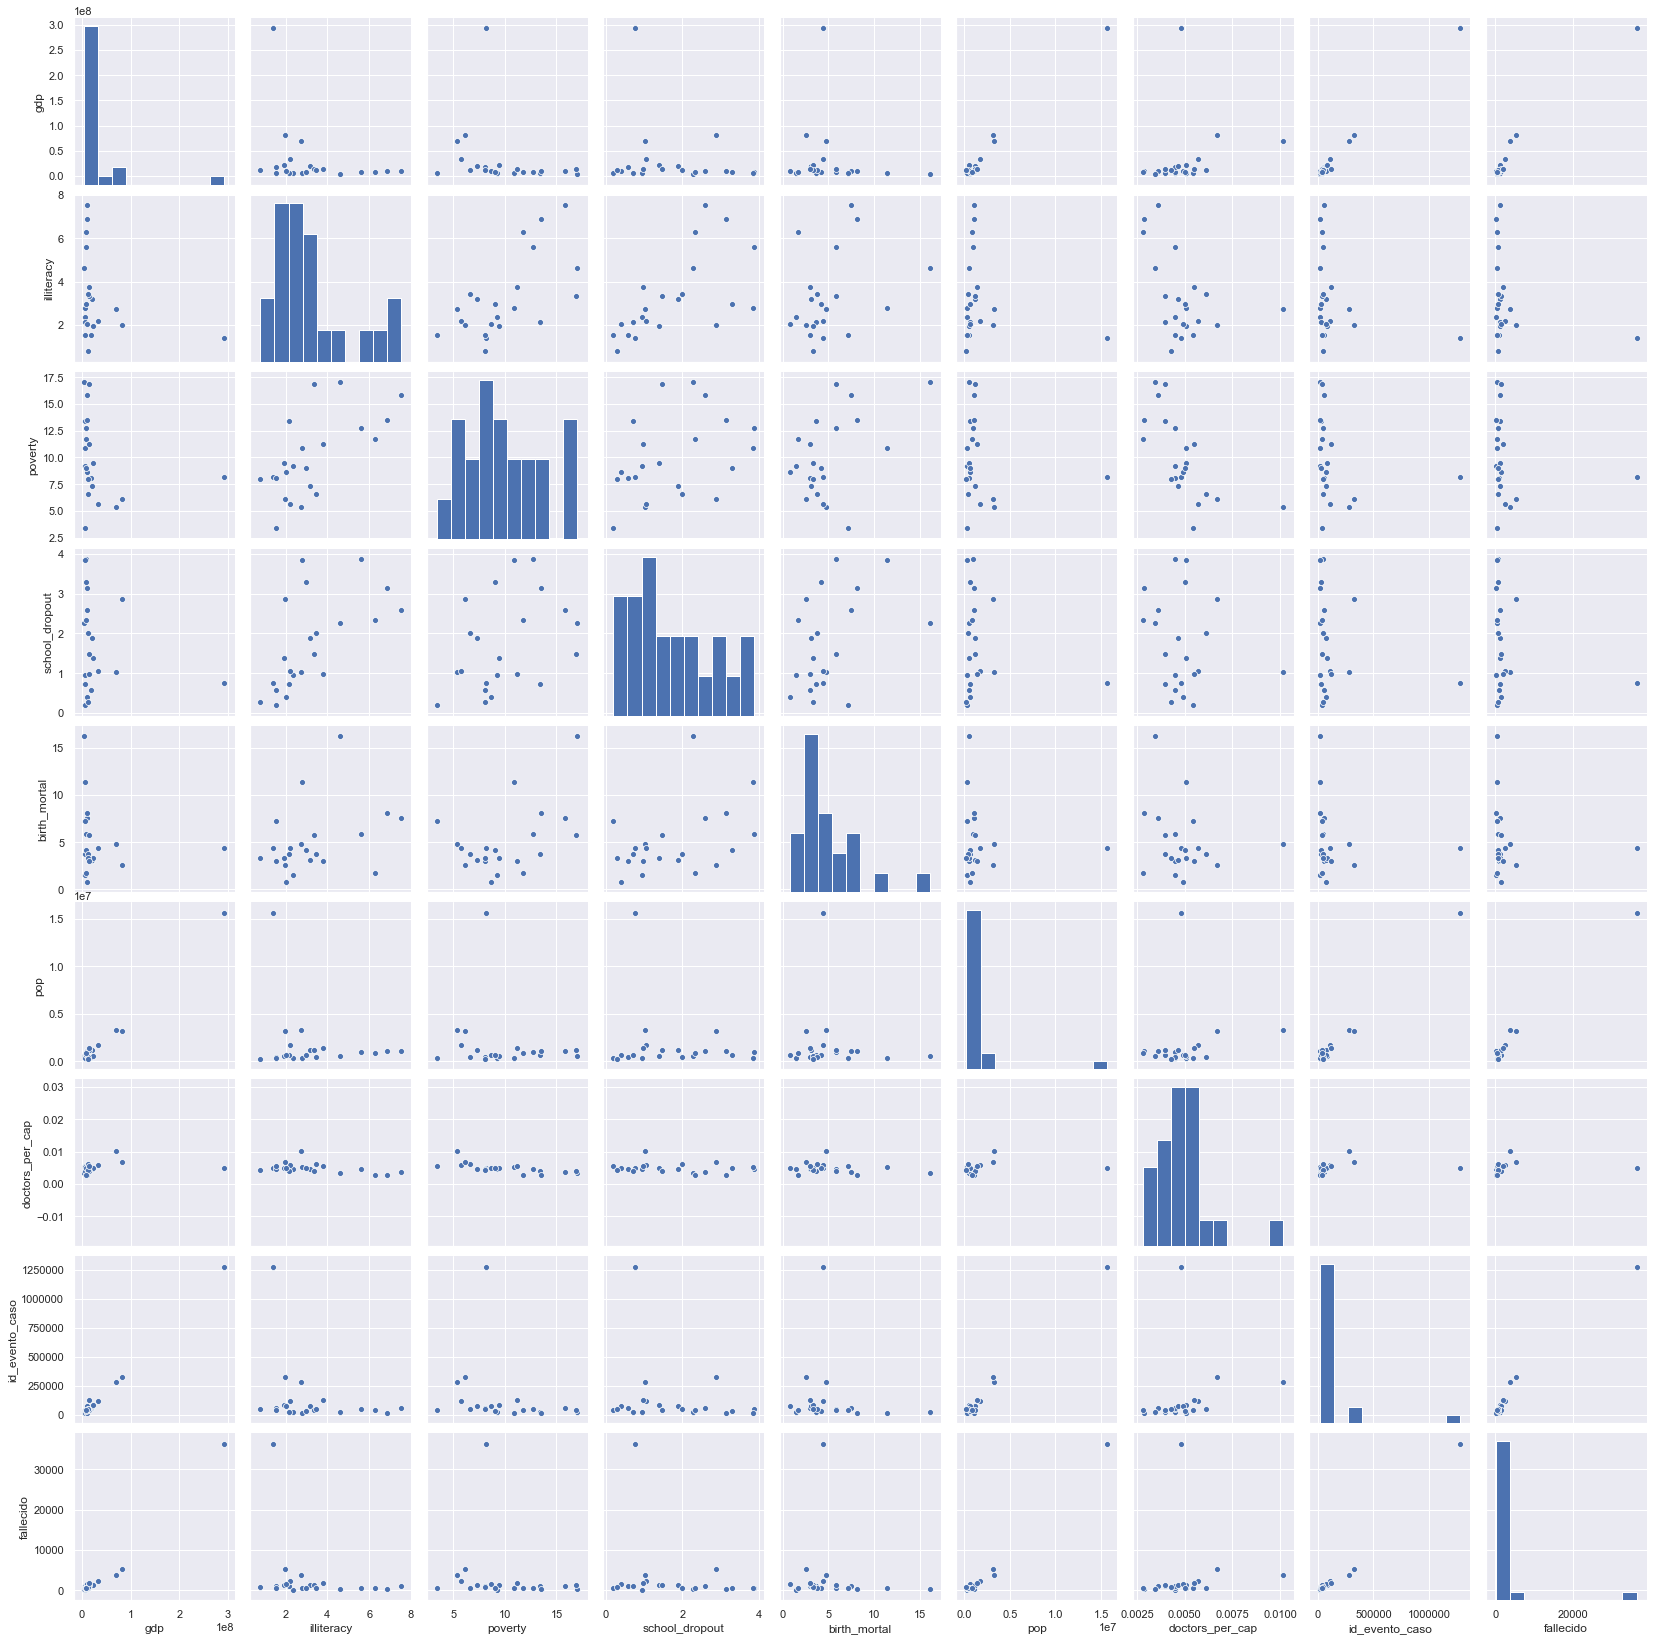

In [188]:
sns.pairplot(datosprovnueva)

Si bien al ser muchas variables, los gráficos quedan pequeños, saltan a la vista relaciones obvias como Pobreza y analfabetismo, o casos confirmados de covid y población

Podemos hacer zoom en alguna relación en particular con scatterplot...

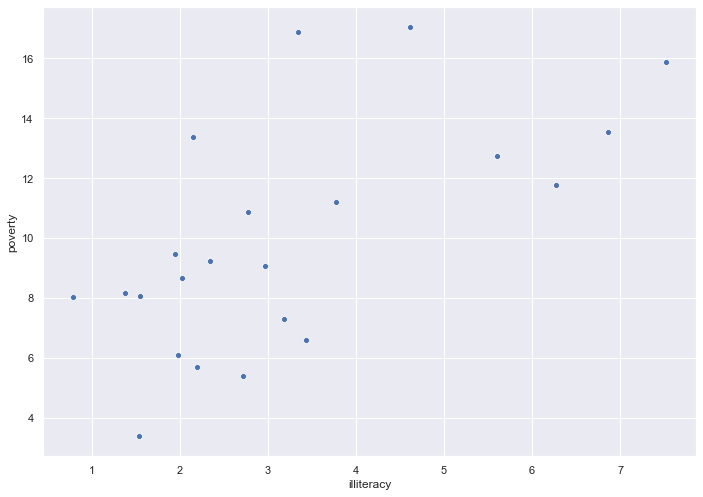

In [229]:
sns.scatterplot(data=datosprovnueva, x="illiteracy", y="poverty")

Lo mimsmo pero incluyendo la estimación de regresión lineal con regplot...

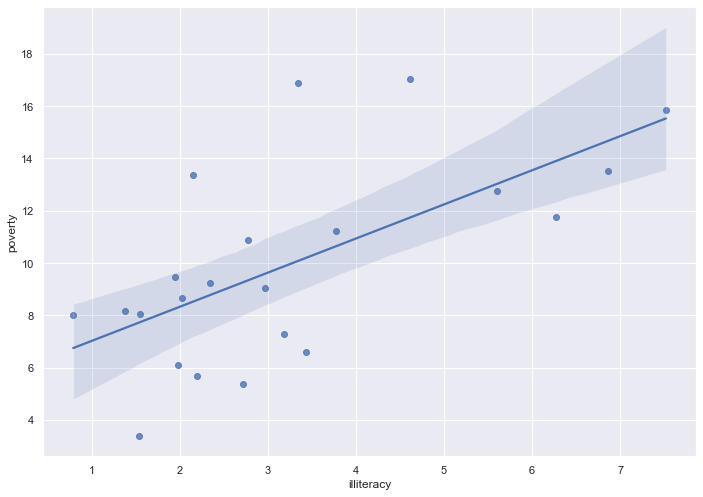

In [230]:
sns.regplot(data=datosprovnueva, x="illiteracy", y="poverty")

Voy a crear una variable categórica totalmente arbitraria para mostrar cómo queda un scatterplot con 'hue'que es una manera de incorporar una tercer variable en el gráfico.
Voy a categorizar provincias pobres y ricas usando la mediana del GDP per cápita como parámetro de comparación.

In [194]:
datosprovnueva['Gdp per capita']=datosprovnueva['gdp']/datosprovnueva['pop']

In [204]:
mediana=datosprovnueva['Gdp per capita'].median()

In [210]:
datosprovnueva['cat_prov']=datosprovnueva['Gdp per capita'].apply(lambda x: 'rica' if x > mediana else 'pobre')

In [214]:
datosprovnueva['fallec_hab']=datosprovnueva['fallecido']/datosprovnueva['pop']

In [217]:
datosprovnueva['confirmados_hab']=datosprovnueva['id_evento_caso']/datosprovnueva['pop']

Text(0.5, 1.0, 'Fallecidos versus doctores por habitantes')

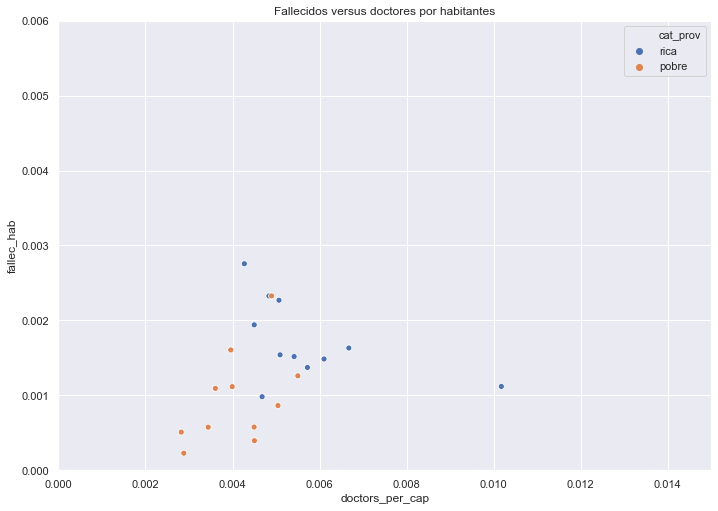

In [228]:
sns.scatterplot(data=datosprovnueva, x="doctors_per_cap", y="fallec_hab",hue='cat_prov')
plt.xlim(0,0.0150)
plt.ylim(0,0.006)
plt.title('Fallecidos versus doctores por habitantes')

Las provincias 'ricas' tienen mejor ratio de doctores per capita pero no necesariamente menos fallecidos por habitante

Con lmplot podemos 'cruzar' un gráfico relacional como scatterplot con una tercer variable categórica. De acuerdo al siguiente gráfico el factor pobreza es más determinante en aquellas provincias ricas, en el abandono escolar en comparación a la provincia pobre.

Text(0.5, 1, 'Pobreza y abandono escolar')

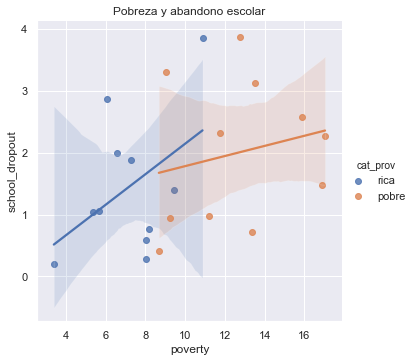

In [226]:
sns.lmplot(x="poverty", y="school_dropout", hue="cat_prov", data=datosprovnueva)
plt.title('Pobreza y abandono escolar')

No quiero olvidarme de swarmplot que es un scatterplot para variable categórica versus continua (no recomendable para bases con muchas observaciones porque puede demorar bastante)

Text(0.5, 1.0, 'Analfabetismo por tipo de provincia')

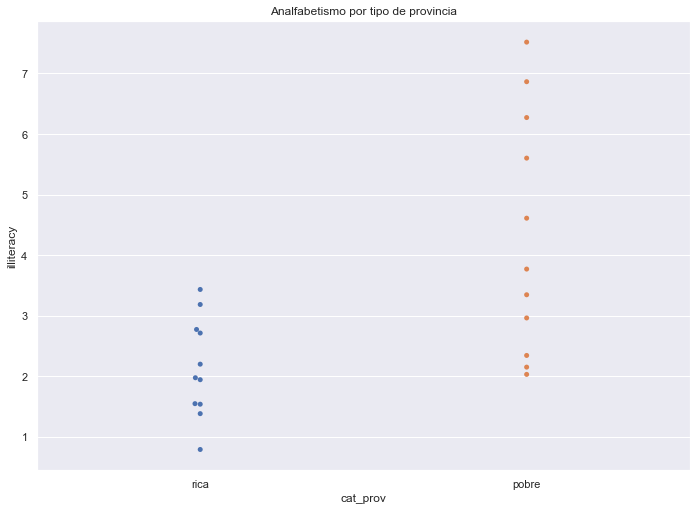

In [225]:
sns.swarmplot(x=datosprovnueva['cat_prov'], y=datosprovnueva['illiteracy'])
plt.title('Analfabetismo por tipo de provincia')

Por último vamos a ensayar un heatmap, básicamente representa por colores la intensidad de relación entre las variables. Seleccionamos unas pocas variables lo más comparables entre si.

In [236]:
cols=['illiteracy', 'poverty', 'school_dropout', 'birth_mortal','doctors_per_cap', 'Gdp per capita','fallec_hab', 'confirmados_hab']
selec=datosprovnueva[cols]
datosprovcorr=selec.corr()

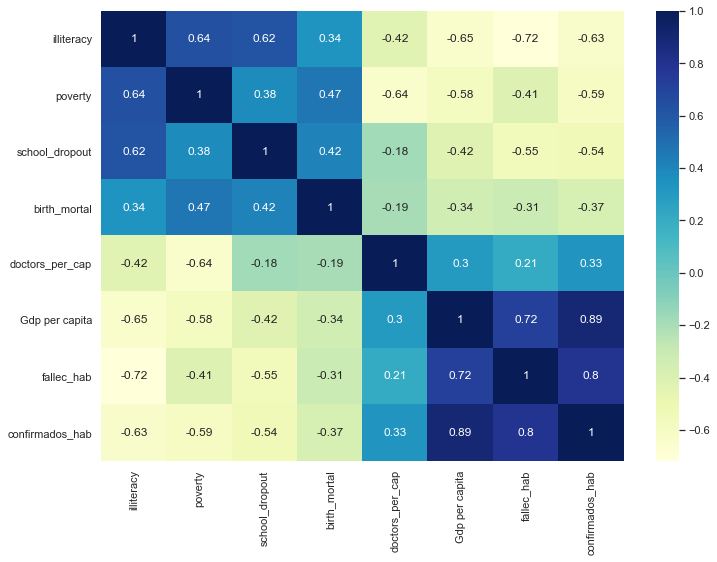

In [243]:
sns.heatmap(datosprovcorr,annot=True,cmap="YlGnBu")